In [ ]:
# Check the number of stations within a region interested

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import xarray as xr
import os
import sys
import glob
import datetime
import re
# Read station metadata from the Excel file
stations = pd.read_excel('/g/data/w28/yk8692/nesp_backup/station/All_stations_information.xlsx')

In [2]:
%%time
file_path = '/g/data/w28/yk8692/nesp_backup'
region_name = "Australian Capital Territory"
region_name_full = "Australian Capital Territory"
# Load the Greater Sydney shapefile
gccsa = gpd.read_file(f"{file_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
# gccsa = gpd.read_file("Greater Capital City Statistical Areas - 2021 - Shapefile.shp")
print("Shapefile columns:", gccsa.columns.tolist())
re_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)]
print(f"Number of polygons for {region_name_full}:", len(re_shp))

# Convert station metadata into a GeoDataFrame.
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Longitude'], stations['Latitude']),
    crs="EPSG:4326"
)

# If necessary
if re_shp.crs != stations_gdf.crs:
    re_shp = re_shp.to_crs(stations_gdf.crs)

# Filter stations that fall within the Greater Sydney region.
stations_in_region = stations_gdf[stations_gdf.within(re_shp.unary_union)]
print(f"Found {len(stations_in_region)} AWS stations within {region_name_full}.")
print(stations_in_region)

Shapefile columns: ['GCC_CODE21', 'GCC_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']
Number of polygons for Australian Capital Territory: 1
Found 4 AWS stations within Australian Capital Territory.
    Record_identifier_st  Station_number  Rainfall_district_code  \
406                   st           70014                    70.0   
410                   st           70339                    70.0   
411                   st           70349                    70.0   
412                   st           70351                    70.0   

                          Station_name Month/Year_site_opened  \
406        CANBERRA AIRPORT COMPARISON                01/1939   
410  TUGGERANONG (ISABELLA PLAINS) AWS                05/1996   
411                   MOUNT GININI AWS                06/2004   
412                   CANBERRA AIRPORT                09/2008   

    Month/Year_site_closed  Latitude  Longitude  

<timed exec>:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


# Extract and store the daily data

In [4]:
import zipfile

In [5]:
def extract_all_zips(zip_folder, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    zip_files = glob.glob(os.path.join(zip_folder, "*.zip"))  # Find all ZIP files

    if not zip_files:
        print("No ZIP files found.")
        return

    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
#            print(f"Extracted: {zip_file}")

    print(f"All ZIP files extracted to: {extract_to}")

# Example usage
zip_folder_path = "/g/data/w28/yk8692/nesp_backup/station_daily"  # Folder containing ZIPs
output_directory = "/g/data/w28/yk8692/nesp_backup/station_daily"  # Extraction folder

extract_all_zips(zip_folder_path, output_directory)

All ZIP files extracted to: /g/data/w28/yk8692/nesp/station_daily


In [6]:
def remove_txt_files(folder_path):
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))  # Find all .txt files
    
    if not txt_files:
        print("No .txt files found.")
        return

    for txt_file in txt_files:
        os.remove(txt_file)
        # print(f"Deleted: {txt_file}")

    print("All .txt files removed.")

remove_txt_files(output_directory)

All .txt files removed.


# Corrected all netcdfs save

In [6]:
# Input directories
netcdf_dir = "/g/data/w28/yk8692/nesp/station"
csv_dir = "/g/data/w28/yk8692/nesp/station_daily"

# Output directory for modified NetCDF files
output_netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected"
prefixes = ['23'] # brisbane ['04','14'], perth ['009'], Adelaide ['23']

# Ensure output directory exists
os.makedirs(output_netcdf_dir, exist_ok=True)

# Regex pattern to extract station number from filenames
# netcdf_pattern = re.compile(r"HD01D_Data_(\d+)_\d+\.nc")
pattern_str = rf"HD01D_Data_((?:{'|'.join(prefixes)})\d*)_\d+\.nc"
netcdf_pattern = re.compile(pattern_str)

# csv_pattern = re.compile(r"IDCJAC0009_(\d+)_\d+_Data\.csv")
csv_pattern = re.compile(rf"IDCJAC0009_((?:{'|'.join(prefixes)})\d*)_\d+_Data\.csv")

# List NetCDF and CSV files
netcdf_files = [f for f in os.listdir(netcdf_dir) if f.endswith(".nc")]
csv_files = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]

# Create a mapping of station numbers to filenames
netcdf_map = {netcdf_pattern.match(f).group(1): f for f in netcdf_files if netcdf_pattern.match(f)}
csv_map = {csv_pattern.match(f).group(1): f for f in csv_files if csv_pattern.match(f)}

# Process each matching station
for station, netcdf_file in netcdf_map.items():
    if station in csv_map:  # Only proceed if we have both NetCDF and CSV for the station
        netcdf_path = os.path.join(netcdf_dir, netcdf_file)
        csv_path = os.path.join(csv_dir, csv_map[station])
        output_netcdf_path = os.path.join(output_netcdf_dir, netcdf_file)

        # Load NetCDF data
        data = xr.open_dataset(netcdf_path, mode="r+")  # Open for reading and writing

        if 'Precipitation' in data.variables:
            ppt = data['Precipitation']  # Precipitation values
            netcdf_times = pd.to_datetime(data["Time"].values)  # Full timestamps (including hours & minutes)
            netcdf_dates = netcdf_times.date  # Extract only date portion (YYYY-MM-DD)

        # Load CSV data
        df = pd.read_csv(csv_path)

        # Check required columns
        required_columns = ["Year", "Month", "Day", "Rainfall amount (millimetres)"]
        if all(col in df.columns for col in required_columns):
            df["date"] = pd.to_datetime(df[["Year", "Month", "Day"]]).dt.date  # Extract only date portion

            # Find unique dates where precipitation is NaN in CSV
            nan_dates = set(df.loc[df["Rainfall amount (millimetres)"].isna(), "date"])  # Use set for faster lookup

            # Find matching indices in NetCDF (all time steps for those dates)
            matching_indices = np.array([d in nan_dates for d in netcdf_dates])

            # Set precipitation to zero in NetCDF for all matching time steps
            ppt.data[matching_indices] = np.nan  # Modify data directly

            # Save modified NetCDF to a new folder
            data.to_netcdf(output_netcdf_path, mode="w")  # Save in a new folder
            print(f"Processed and saved: {output_netcdf_path}")

        data.close()  # Close NetCDF file


KeyboardInterrupt



# Plot all stations

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import re

# Directory containing the NetCDF files
netcdf_dir = output_netcdf_dir

# List NetCDF files in the directory
netcdf_files = [f for f in os.listdir(netcdf_dir) if f.endswith(".nc")]

# Number of rows and columns for the subplots
nrows = 4
ncols = 4

# Create a figure for plotting with 6 rows and 4 columns
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through the NetCDF files and plot each station
for i, netcdf_file in enumerate(netcdf_files):
    netcdf_path = os.path.join(netcdf_dir, netcdf_file)

    # Load NetCDF data
    data = xr.open_dataset(netcdf_path)

    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality control filter
        ppt_quality_controlled = ppt.where(ppt_q == 'Y')
        
        ppt_quality_controlled = ppt_quality_controlled.where(ppt_quality_controlled <= 50)

        # Plot the precipitation data
        axes[i].plot(ppt_quality_controlled['Time'].values, ppt_quality_controlled.values, marker='o')
        axes[i].set_title(f"Precipitation for Station {netcdf_file.split('_')[2]}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Precipitation (mm)')
        axes[i].grid(True)

    data.close()  # Close the NetCDF file

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.dates as mdates

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station"

station_numbers = ['086038', '086068', '086071', '086077', '086104', '086266', 
                   '086282', '086338', '086361', '086371', '086372', '086383', 
                   '086388', '087031', '087185', '088162']

# Generate the list of matching NetCDF files for each station
netcdf_files = []

for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensures leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"
    
    # Find all matching files in the directory
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]
    
    netcdf_files.extend(matching_files)

# Set up a visually appealing plot style
plt.style.use("seaborn-v0_8-darkgrid")

# Determine grid layout based on number of files
ncols = 4
nrows = 4

# Create figure and axes
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 14), constrained_layout=True)
axes = axes.flatten()  # Flatten for easier indexing

# Loop through NetCDF files and plot each station
for i, netcdf_file in enumerate(netcdf_files):
    netcdf_path = os.path.join(netcdf_dir, netcdf_file)

    # Load NetCDF data
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        if ppt_quality_controlled.size > 0:  # Ensure there is data to plot
            ax = axes[i]

            # Scatter plot for better visibility
            ax.scatter(
                ppt_quality_controlled['Time'].values, ppt_quality_controlled.values,
                c="dodgerblue", edgecolors="black", alpha=0.7, label="Filtered Precipitation"
            )

            # Format date axis
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

            # Improve title formatting
            station_id = netcdf_file.split('_')[2]
            ax.set_title(f"Station {station_id}", fontsize=12, fontweight="bold")

            # Labels and grid
            ax.set_xlabel('Time', fontsize=10)
            ax.set_ylabel('Precipitation (mm)', fontsize=10)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Rotate x-axis labels for better readability
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    data.close()  # Close NetCDF file

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.show()


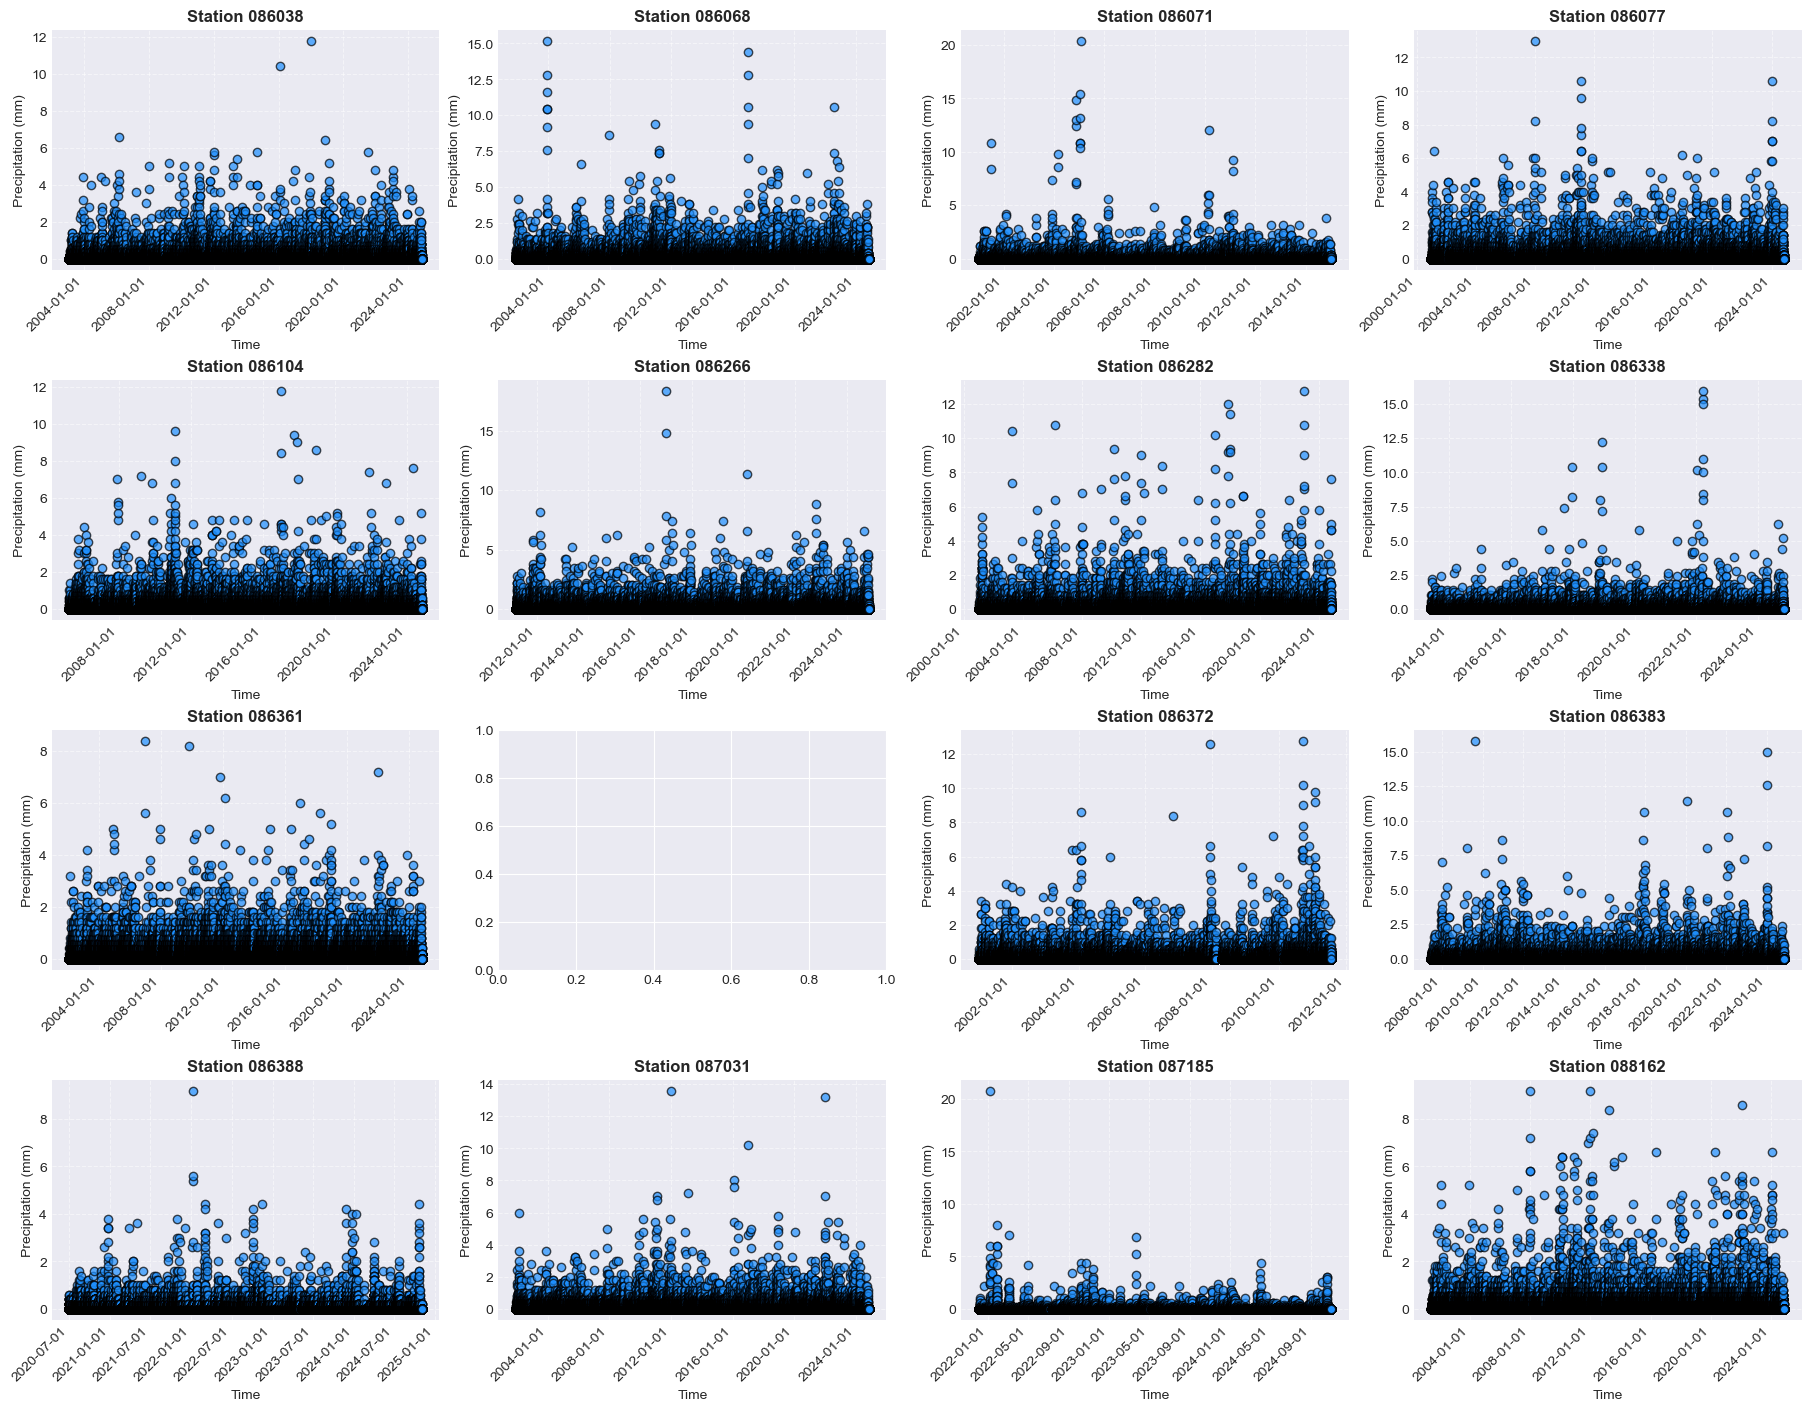

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.dates as mdates

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected_rv"

station_numbers = ['086038', '086068', '086071', '086077', '086104', '086266', 
                   '086282', '086338', '086361', '086371', '086372', '086383', 
                   '086388', '087031', '087185', '088162']

# Generate the list of matching NetCDF files for each station
netcdf_files = []

for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensures leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"
    
    # Find all matching files in the directory
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]
    
    netcdf_files.extend(matching_files)

# Set up a visually appealing plot style
plt.style.use("seaborn-v0_8-darkgrid")

# Determine grid layout based on number of files
ncols = 4
nrows = 4

# Create figure and axes
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 14), constrained_layout=True)
axes = axes.flatten()  # Flatten for easier indexing

# Loop through NetCDF files and plot each station
for i, netcdf_file in enumerate(netcdf_files):
    netcdf_path = os.path.join(netcdf_dir, netcdf_file)

    # Load NetCDF data
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        if ppt_quality_controlled.size > 0:  # Ensure there is data to plot
            ax = axes[i]

            # Scatter plot for better visibility
            ax.scatter(
                ppt_quality_controlled['Time'].values, ppt_quality_controlled.values,
                c="dodgerblue", edgecolors="black", alpha=0.7, label="Filtered Precipitation"
            )

            # Format date axis
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

            # Improve title formatting
            station_id = netcdf_file.split('_')[2]
            ax.set_title(f"Station {station_id}", fontsize=12, fontweight="bold")

            # Labels and grid
            ax.set_xlabel('Time', fontsize=10)
            ax.set_ylabel('Precipitation (mm)', fontsize=10)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Rotate x-axis labels for better readability
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    data.close()  # Close NetCDF file

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.show()


In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.dates as mdates

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected_rv"

station_numbers = [
    '009193', '009172', '009281', '009225', '009240',
    '009977', '009256', '009021', '009053', '009215'
]

# Generate the list of matching NetCDF files for each station
netcdf_files = []

for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensures leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"
    
    # Find all matching files in the directory
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]
    
    netcdf_files.extend(matching_files)

# Set up a visually appealing plot style
plt.style.use("seaborn-v0_8-darkgrid")

# Determine grid layout based on number of files
ncols = 4
nrows = 4

# Create figure and axes
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 14), constrained_layout=True)
axes = axes.flatten()  # Flatten for easier indexing

# Loop through NetCDF files and plot each station
for i, netcdf_file in enumerate(netcdf_files):
    netcdf_path = os.path.join(netcdf_dir, netcdf_file)

    # Load NetCDF data
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        if ppt_quality_controlled.size > 0:  # Ensure there is data to plot
            ax = axes[i]

            # Scatter plot for better visibility
            ax.scatter(
                ppt_quality_controlled['Time'].values, ppt_quality_controlled.values,
                c="dodgerblue", edgecolors="black", alpha=0.7, label="Filtered Precipitation"
            )

            # Format date axis
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

            # Improve title formatting
            station_id = netcdf_file.split('_')[2]
            ax.set_title(f"Station {station_id}", fontsize=12, fontweight="bold")

            # Labels and grid
            ax.set_xlabel('Time', fontsize=10)
            ax.set_ylabel('Precipitation (mm)', fontsize=10)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Rotate x-axis labels for better readability
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    data.close()  # Close NetCDF file

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.show()


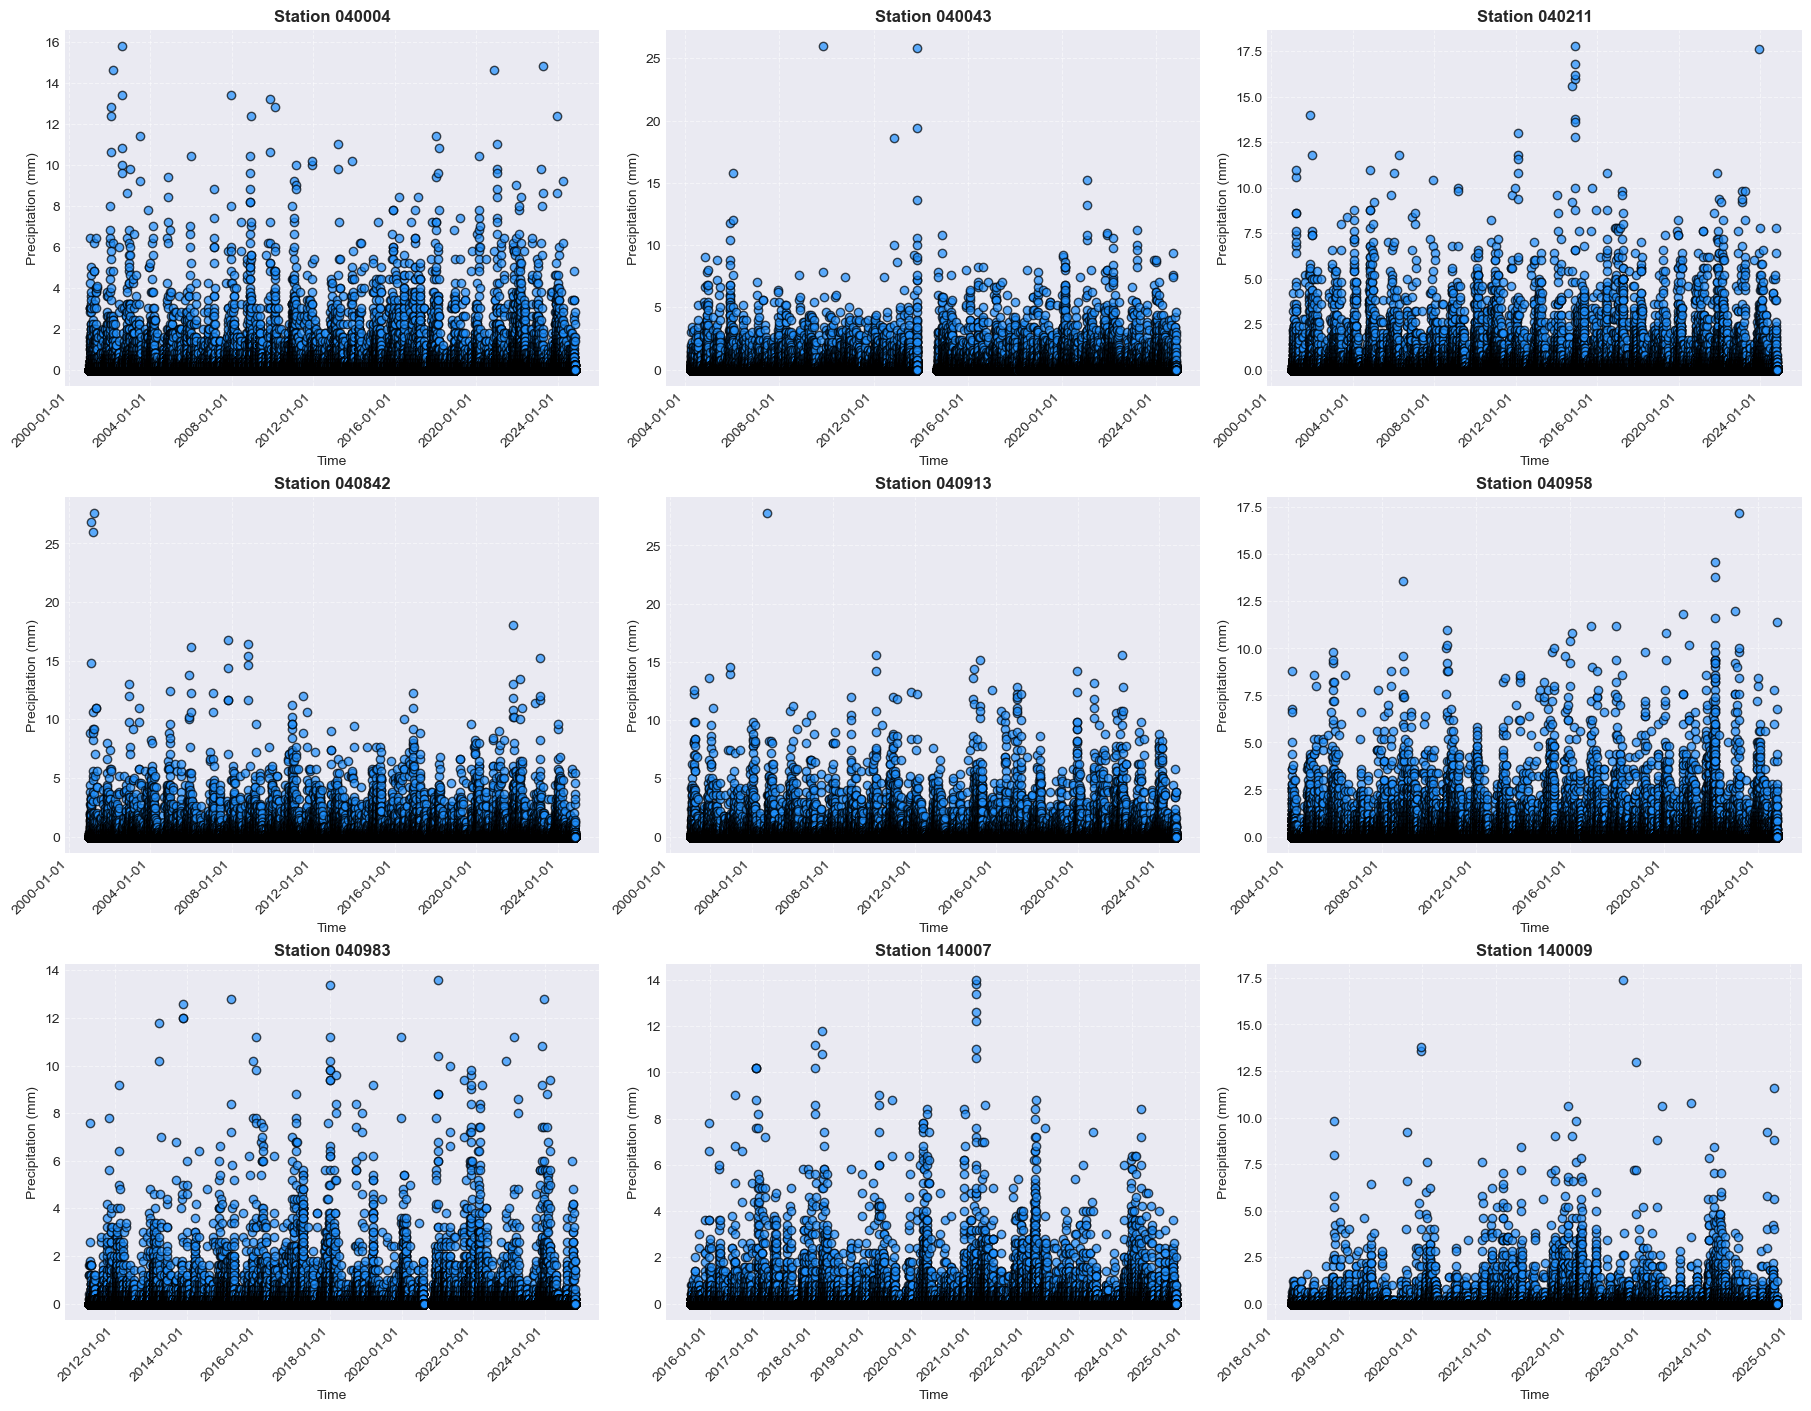

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.dates as mdates

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected_rv"

station_numbers = [
    '040004', '040043', '040211', '040842', '040913',
    '040958', '040983', '140007', '140009'
]

# Generate the list of matching NetCDF files for each station
netcdf_files = []

for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensures leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"
    
    # Find all matching files in the directory
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]
    
    netcdf_files.extend(matching_files)

# Set up a visually appealing plot style
plt.style.use("seaborn-v0_8-darkgrid")

# Determine grid layout based on number of files
ncols = 3
nrows = 3

# Create figure and axes
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 14), constrained_layout=True)
axes = axes.flatten()  # Flatten for easier indexing

# Loop through NetCDF files and plot each station
for i, netcdf_file in enumerate(netcdf_files):
    netcdf_path = os.path.join(netcdf_dir, netcdf_file)

    # Load NetCDF data
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        if ppt_quality_controlled.size > 0:  # Ensure there is data to plot
            ax = axes[i]

            # Scatter plot for better visibility
            ax.scatter(
                ppt_quality_controlled['Time'].values, ppt_quality_controlled.values,
                c="dodgerblue", edgecolors="black", alpha=0.7, label="Filtered Precipitation"
            )

            # Format date axis
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

            # Improve title formatting
            station_id = netcdf_file.split('_')[2]
            ax.set_title(f"Station {station_id}", fontsize=12, fontweight="bold")

            # Labels and grid
            ax.set_xlabel('Time', fontsize=10)
            ax.set_ylabel('Precipitation (mm)', fontsize=10)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Rotate x-axis labels for better readability
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    data.close()  # Close NetCDF file

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.show()


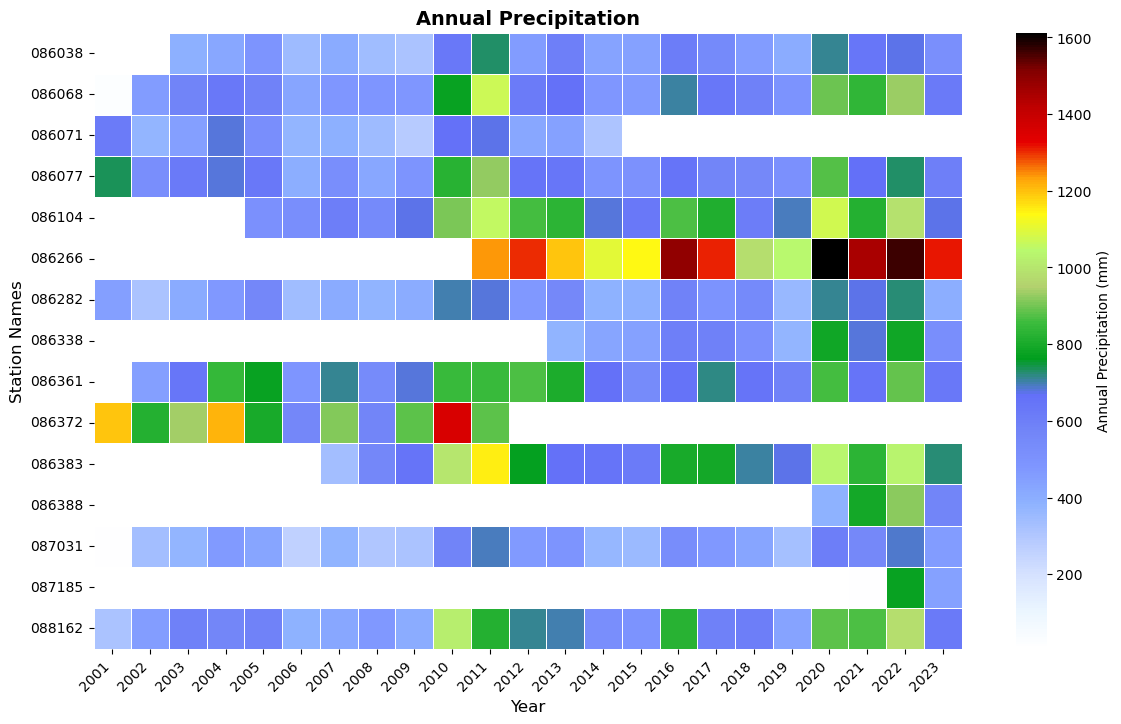

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected_rv"

# List of station numbers
station_numbers = ['086038', '086068', '086071', '086077', '086104', '086266', 
                   '086282', '086338', '086361', '086372', '086383', 
                   '086388', '087031', '087185', '088162']

# Create a dictionary to store annual precipitation data for each station
annual_precip_data = {}

# Loop through each station
for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensure leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"

    # Find matching files
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]

    if not matching_files:
        continue  # Skip if no data found for the station

    # Load NetCDF data for the first matching file (assuming one file per station)
    netcdf_path = os.path.join(netcdf_dir, matching_files[0])
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        # Convert to Pandas DataFrame
        df = ppt_quality_controlled.to_dataframe().reset_index()

        # Ensure 'Time' is a datetime object
        df['Time'] = pd.to_datetime(df['Time'])

        # Group by year and sum precipitation
        annual_precip = df.groupby(df['Time'].dt.year)['Precipitation'].sum()

        # Store in dictionary
        annual_precip_data[station] = annual_precip

    data.close()  # Close NetCDF file

from matplotlib.colors import LinearSegmentedColormap

# Define the precip2_17lev colormap (custom definition)
precip2_17lev_colors = [
    (255/255, 255/255, 255/255),  # White
    (235/255, 246/255, 255/255),  # Light Blue
    (214/255, 226/255, 255/255),  # Sky Blue
    (181/255, 201/255, 255/255),  # Blue
    (142/255, 178/255, 255/255),  # Light Royal Blue
    (127/255, 150/255, 255/255),  # Medium Blue
    (114/255, 133/255, 248/255),  # Royal Blue
    (99/255, 112/255, 248/255),   # Deep Blue
    (0/255, 158/255, 30/255),     # Green
    (60/255, 188/255, 61/255),    # Bright Green
    (179/255, 209/255, 110/255),  # Pale Green
    (185/255, 249/255, 110/255),  # Lime Green
    (255/255, 249/255, 19/255),   # Yellow
    (255/255, 163/255, 9/255),    # Orange
    (229/255, 0/255, 0/255),      # Red
    (189/255, 0/255, 0/255),      # Dark Red
    (129/255, 0/255, 0/255),      # Deep Red
    (0/255, 0/255, 0/255),        # Black
]
precip2_17lev = LinearSegmentedColormap.from_list("precip2_17lev", precip2_17lev_colors)

# Convert dictionary to DataFrame
annual_precip_df = pd.DataFrame(annual_precip_data).T  # Transpose so stations are rows and years are columns
annual_precip_df.index.name = "Station Names"
# Exclude the 2024 column from the heatmap
annual_precip_df = annual_precip_df.loc[:, annual_precip_df.columns != 2024]

# Plot heatmap
plt.figure(figsize=(14, 8))
# ax = sns.heatmap(annual_precip_df, cmap="YlGnBu", linewidths=0.5, annot=False)
ax = sns.heatmap(annual_precip_df, cmap=precip2_17lev, linewidths=0.5, annot=False)

# Labels and title
plt.title("Annual Precipitation", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Station Names", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Annual Precipitation (mm)")
shape_path = '/g/data/w28/yk8692/nesp'
plt.savefig(f'{shape_path}/figure/annual_P_melbourne_with_station_numbers.jpg', format='jpg', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


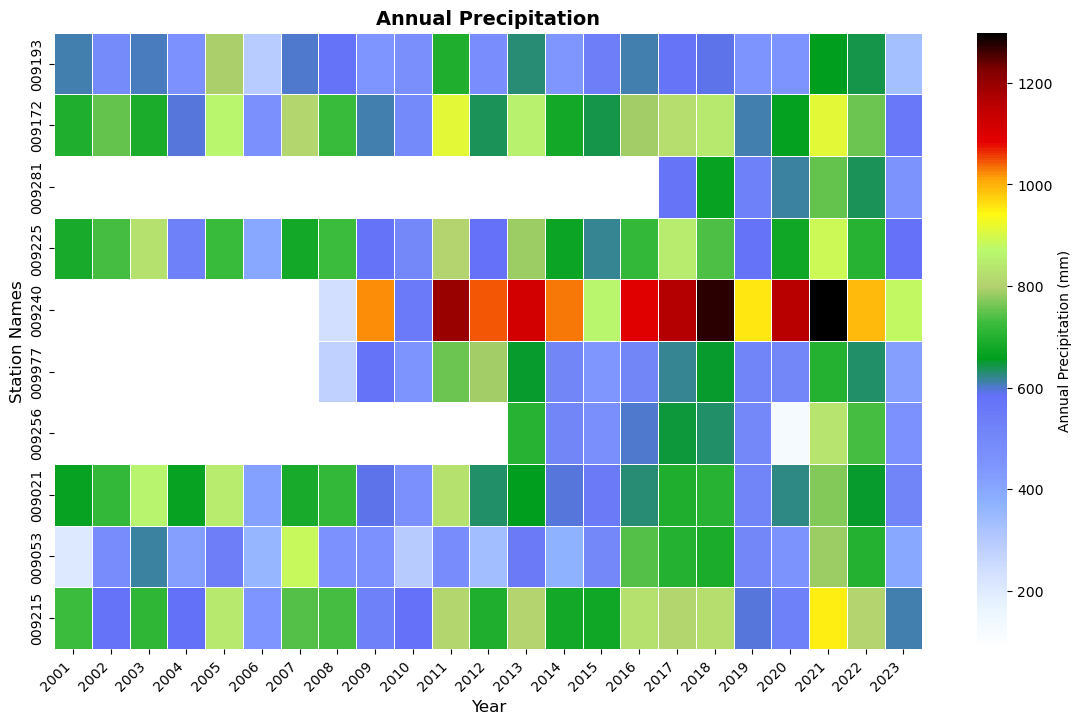

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected_rv"

# List of station numbers
station_numbers = [
    '009193', '009172', '009281', '009225', '009240',
    '009977', '009256', '009021', '009053', '009215'
]

# Create a dictionary to store annual precipitation data for each station
annual_precip_data = {}

# Loop through each station
for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensure leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"

    # Find matching files
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]

    if not matching_files:
        continue  # Skip if no data found for the station

    # Load NetCDF data for the first matching file (assuming one file per station)
    netcdf_path = os.path.join(netcdf_dir, matching_files[0])
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        # Convert to Pandas DataFrame
        df = ppt_quality_controlled.to_dataframe().reset_index()

        # Ensure 'Time' is a datetime object
        df['Time'] = pd.to_datetime(df['Time'])

        # Group by year and sum precipitation
        annual_precip = df.groupby(df['Time'].dt.year)['Precipitation'].sum()

        # Store in dictionary
        annual_precip_data[station] = annual_precip

    data.close()  # Close NetCDF file

from matplotlib.colors import LinearSegmentedColormap

# Define the precip2_17lev colormap (custom definition)
precip2_17lev_colors = [
    (255/255, 255/255, 255/255),  # White
    (235/255, 246/255, 255/255),  # Light Blue
    (214/255, 226/255, 255/255),  # Sky Blue
    (181/255, 201/255, 255/255),  # Blue
    (142/255, 178/255, 255/255),  # Light Royal Blue
    (127/255, 150/255, 255/255),  # Medium Blue
    (114/255, 133/255, 248/255),  # Royal Blue
    (99/255, 112/255, 248/255),   # Deep Blue
    (0/255, 158/255, 30/255),     # Green
    (60/255, 188/255, 61/255),    # Bright Green
    (179/255, 209/255, 110/255),  # Pale Green
    (185/255, 249/255, 110/255),  # Lime Green
    (255/255, 249/255, 19/255),   # Yellow
    (255/255, 163/255, 9/255),    # Orange
    (229/255, 0/255, 0/255),      # Red
    (189/255, 0/255, 0/255),      # Dark Red
    (129/255, 0/255, 0/255),      # Deep Red
    (0/255, 0/255, 0/255),        # Black
]
precip2_17lev = LinearSegmentedColormap.from_list("precip2_17lev", precip2_17lev_colors)

# Convert dictionary to DataFrame
annual_precip_df = pd.DataFrame(annual_precip_data).T  # Transpose so stations are rows and years are columns
annual_precip_df.index.name = "Station Names"
# Exclude the 2024 column from the heatmap
annual_precip_df = annual_precip_df.loc[:, annual_precip_df.columns != 2024]

# Plot heatmap
plt.figure(figsize=(14, 8))
# ax = sns.heatmap(annual_precip_df, cmap="YlGnBu", linewidths=0.5, annot=False)
ax = sns.heatmap(annual_precip_df, cmap=precip2_17lev, linewidths=0.5, annot=False)

# Labels and title
plt.title("Annual Precipitation", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Station Names", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Annual Precipitation (mm)")
shape_path = '/g/data/w28/yk8692/nesp'
plt.savefig(f'{shape_path}/figure/annual_P_{region}_with_station_numbers.jpg', format='jpg', dpi=300, bbox_inches='tight')

# Show plot
plt.show()
plt.close()

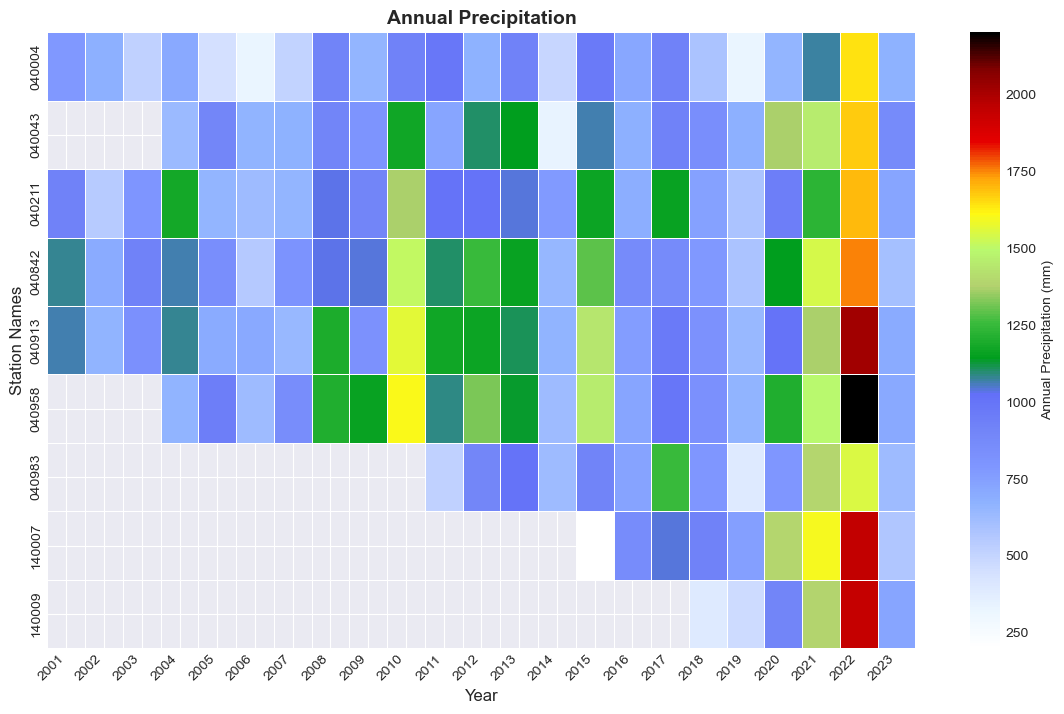

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

# Directory containing the NetCDF files
netcdf_dir = "/g/data/w28/yk8692/nesp/station_corrected_rv"

# List of station numbers
station_numbers = [
    '040004', '040043', '040211', '040842', '040913',
    '040958', '040983', '140007', '140009'
]

# Create a dictionary to store annual precipitation data for each station
annual_precip_data = {}

# Loop through each station
for station in station_numbers:
    station_num_str = f"{int(station):06d}"  # Ensure leading zeros are retained
    pattern = f"HD01D_Data_{station_num_str}_*.nc"

    # Find matching files
    matching_files = [f for f in os.listdir(netcdf_dir) if f.startswith(f"HD01D_Data_{station_num_str}_") and f.endswith(".nc")]

    if not matching_files:
        continue  # Skip if no data found for the station

    # Load NetCDF data for the first matching file (assuming one file per station)
    netcdf_path = os.path.join(netcdf_dir, matching_files[0])
    data = xr.open_dataset(netcdf_path)

    # Extract precipitation data with quality control
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality filter and remove extreme values
        ppt_quality_controlled = ppt.where((ppt_q == 'Y') & (ppt <= 50), drop=True)

        # Convert to Pandas DataFrame
        df = ppt_quality_controlled.to_dataframe().reset_index()

        # Ensure 'Time' is a datetime object
        df['Time'] = pd.to_datetime(df['Time'])

        # Group by year and sum precipitation
        annual_precip = df.groupby(df['Time'].dt.year)['Precipitation'].sum()

        # Store in dictionary
        annual_precip_data[station] = annual_precip

    data.close()  # Close NetCDF file

from matplotlib.colors import LinearSegmentedColormap

# Define the precip2_17lev colormap (custom definition)
precip2_17lev_colors = [
    (255/255, 255/255, 255/255),  # White
    (235/255, 246/255, 255/255),  # Light Blue
    (214/255, 226/255, 255/255),  # Sky Blue
    (181/255, 201/255, 255/255),  # Blue
    (142/255, 178/255, 255/255),  # Light Royal Blue
    (127/255, 150/255, 255/255),  # Medium Blue
    (114/255, 133/255, 248/255),  # Royal Blue
    (99/255, 112/255, 248/255),   # Deep Blue
    (0/255, 158/255, 30/255),     # Green
    (60/255, 188/255, 61/255),    # Bright Green
    (179/255, 209/255, 110/255),  # Pale Green
    (185/255, 249/255, 110/255),  # Lime Green
    (255/255, 249/255, 19/255),   # Yellow
    (255/255, 163/255, 9/255),    # Orange
    (229/255, 0/255, 0/255),      # Red
    (189/255, 0/255, 0/255),      # Dark Red
    (129/255, 0/255, 0/255),      # Deep Red
    (0/255, 0/255, 0/255),        # Black
]
precip2_17lev = LinearSegmentedColormap.from_list("precip2_17lev", precip2_17lev_colors)

# Convert dictionary to DataFrame
annual_precip_df = pd.DataFrame(annual_precip_data).T  # Transpose so stations are rows and years are columns
annual_precip_df.index.name = "Station Names"
# Exclude the 2024 column from the heatmap
annual_precip_df = annual_precip_df.loc[:, annual_precip_df.columns != 2024]

# Plot heatmap
plt.figure(figsize=(14, 8))
# ax = sns.heatmap(annual_precip_df, cmap="YlGnBu", linewidths=0.5, annot=False)
ax = sns.heatmap(annual_precip_df, cmap=precip2_17lev, linewidths=0.5, annot=False)

# Labels and title
plt.title("Annual Precipitation", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Station Names", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Annual Precipitation (mm)")
shape_path = '/g/data/w28/yk8692/nesp'
plt.savefig(f'{shape_path}/figure/annual_P_{region_name}_with_station_numbers.jpg', format='jpg', dpi=300, bbox_inches='tight')

# Show plot
plt.show()
plt.close()

In [2]:
import os, glob, re, xarray as xr, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# --- Configuration ---
regions = {
    # 'Sydney':      ['06'],
    'Melbourne':   ['08'],
    'Brisbane':    ['04','14'],
    'Perth':       ['009'],
    'Adelaide':    ['02','23'],  # include both forms if needed
    'Hobart':      ['09'],
    'Darwin':      ['01'],
    'ACT':         ['07']
}

# Root directory containing corrected station files (adjust if needed)
netcdf_root = '/g/data/w28/yk8692/nesp_backup/station_corrected_rv'
output_dir    = '/g/data/w28/yk8692/nesp_backup/figure'
os.makedirs(output_dir, exist_ok=True)

# Custom colormap (reusing existing definition)
precip2_17lev_colors = [
    (255/255,255/255,255/255),(235/255,246/255,255/255),(214/255,226/255,255/255),
    (181/255,201/255,255/255),(142/255,178/255,255/255),(127/255,150/255,255/255),
    (114/255,133/255,248/255),(99/255,112/255,248/255),(0/255,158/255,30/255),
    (60/255,188/255,61/255),(179/255,209/255,110/255),(185/255,249/255,110/255),
    (255/255,249/255,19/255),(255/255,163/255,9/255),(229/255,0/255,0/255),
    (189/255,0/255,0/255),(129/255,0/255,0/255),(0/255,0/255,0/255)
 ]
precip2_17lev = LinearSegmentedColormap.from_list('precip2_17lev', precip2_17lev_colors)

def collect_files_for_prefixes(prefix_list):
    files = []
    for p in prefix_list:
        # Pattern allows either 2 or 3 digit prefixes in existing naming (e.g., 009, 06, 23)
        pattern = f"HD01D_Data_{p}*_*.nc"
        found = glob.glob(os.path.join(netcdf_root, pattern))
        files.extend(found)
    return sorted(files)

def aggregate_annual_precip(nc_path):
    try:
        with xr.open_dataset(nc_path) as ds:
            if 'Precipitation' not in ds or 'Precipitation Quality' not in ds:
                return None, None
            ppt  = ds['Precipitation']
            pptq = ds['Precipitation Quality']
            ppt_qc = ppt.where((pptq == 'Y') & (ppt <= 50), drop=True)
            if ppt_qc.size == 0:
                return None, None
            df = ppt_qc.to_dataframe().reset_index()
            df['Time'] = pd.to_datetime(df['Time'])
            annual = df.groupby(df['Time'].dt.year)['Precipitation'].sum()
            station_id = os.path.basename(nc_path).split('_')[2]
            return station_id, annual
    except Exception as e:
        print(f"Failed {nc_path}: {e}")
        return None, None

def build_dataframe(series_dict):
    if not series_dict:
        return pd.DataFrame()
    return pd.DataFrame(series_dict).T

def plot_heatmap(df, region):
    if df.empty:
        print(f"No data for region {region}")
        return None
    # Drop 2024 if present
    if 2024 in df.columns:
        df = df.drop(columns=[2024])
    plt.figure(figsize=(14,8))
    ax = sns.heatmap(df, cmap=precip2_17lev, linewidths=0.5, annot=False)
    plt.title(f"Annual Precipitation - {region}", fontsize=14, fontweight='bold')
    plt.xlabel('Year'); plt.ylabel('Station ID')
    plt.xticks(rotation=45, ha='right')
    cbar = ax.collections[0].colorbar
    cbar.set_label('Annual Precipitation (mm)')
    out_path = os.path.join(output_dir, f"annual_P_{region.replace(' ','_')}_with_station_numbers_revised.jpg")
    plt.savefig(out_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved {out_path}")
    return out_path

# --- Main generation loop ---
summary = {}
for region, prefixes in regions.items():
    print(f"Processing region: {region} (prefixes {prefixes})")
    files = collect_files_for_prefixes(prefixes)
    print(f"  Found {len(files)} files")
    series_map = {}
    for fpath in files:
        sid, annual = aggregate_annual_precip(fpath)
        if sid is not None:
            series_map[sid] = annual
    df = build_dataframe(series_map)
    saved = plot_heatmap(df, region)
    summary[region] = {'n_files': len(files), 'n_stations': len(df), 'figure': saved}

print('Done. Summary:')
for k,v in summary.items():
    print(k, v)

Processing region: Melbourne (prefixes ['08'])
  Found 16 files
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Melbourne_with_station_numbers_revised.jpg
Processing region: Brisbane (prefixes ['04', '14'])
  Found 9 files
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Brisbane_with_station_numbers_revised.jpg
Processing region: Perth (prefixes ['009'])
  Found 10 files
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Perth_with_station_numbers_revised.jpg
Processing region: Adelaide (prefixes ['02', '23'])
  Found 9 files
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Adelaide_with_station_numbers_revised.jpg
Processing region: Hobart (prefixes ['09'])
  Found 6 files
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Hobart_with_station_numbers_revised.jpg
Processing region: Darwin (prefixes ['01'])
  Found 6 files
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Darwin_with_station_numbers_revised.jpg
Processing region: ACT (prefixes ['07'])
  Found 4 file